In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as st
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler

In [2]:
clean_final_df = pd.read_csv('D:/DO_NOT_REMOVE/Data_Analyst_Junior/7_11/Данные для кейса/funnel_info_3.csv')
clean_final_df.shape

(981498, 7)

In [3]:
clean_final_df.head()

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,151184,interest,225688,0.0,iOS,search,1.5
1,720354,purchase,225495,50.0,Android,organic_traffic,0.0
2,947521,consideration,225482,0.0,Android,organic_traffic,0.0
3,1034498,intent,225430,0.0,iOS,search,1.5
4,929180,intent,224682,0.0,iOS,search,1.5


### Разделите данные на две группы

- органический трафик (прямые ссылки на сайт и поисковые переходы, за которые рекламодатель не платит);

- рекламный трафик (всё остальное).

In [19]:
organic_df = clean_final_df[clean_final_df['ad_channel']== 'organic_traffic']
organic_df

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
1,720354,purchase,225495,50.0,Android,organic_traffic,0.0
2,947521,consideration,225482,0.0,Android,organic_traffic,0.0
7,706604,intent,223417,0.0,iOS,organic_traffic,0.0
9,104960,purchase,223361,520.0,iOS,organic_traffic,0.0
15,750226,purchase,222773,260.0,Android,organic_traffic,0.0
...,...,...,...,...,...,...,...
981481,286799,interest,150001,0.0,Android,organic_traffic,0.0
981493,897013,interest,150000,0.0,Android,organic_traffic,0.0
981494,242700,interest,150000,0.0,Android,organic_traffic,0.0
981495,143856,interest,150000,0.0,Android,organic_traffic,0.0


In [18]:
not_organic_df = clean_final_df[clean_final_df['ad_channel']!= 'organic_traffic']
not_organic_df

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,151184,interest,225688,0.0,iOS,search,1.5
3,1034498,intent,225430,0.0,iOS,search,1.5
4,929180,intent,224682,0.0,iOS,search,1.5
5,749577,purchase,224647,2136.0,iOS,search,1.5
6,501946,intent,224125,0.0,Android,search,1.5
...,...,...,...,...,...,...,...
981489,795063,interest,150000,0.0,Android,banner,0.5
981490,108759,interest,150000,0.0,Android,banner,0.5
981491,335514,interest,150000,0.0,Android,banner,0.5
981492,219687,interest,150000,0.0,Android,banner,0.5


In [13]:
print (clean_final_df.shape[0],' = ', not_organic_df.shape[0]+organic_df.shape[0])

981498  =  981498


### Сравните доли пользователей на каждом этапе воронки между двумя группами. Насколько статистически значимы отличия между долями? Примените знакомые вам статистические критерии (подсказка: можно рассмотреть критерий долей).

In [34]:
stages = clean_final_df.funnel_stage.unique().tolist()
stages

['interest', 'purchase', 'consideration', 'intent']

In [20]:
stage_conversion_organic = (organic_df[['funnel_stage', 'user_id']].groupby(by='funnel_stage').count())/organic_df.shape[0]
stage_conversion_organic

,user_id
funnel_stage,
consideration,0.379294
intent,0.064369
interest,0.552500
purchase,0.003836


In [21]:
stage_conversion_not_organic = (not_organic_df[['funnel_stage', 'user_id']].groupby(by='funnel_stage').count())/not_organic_df.shape[0]
stage_conversion_not_organic

,user_id
funnel_stage,
consideration,0.341005
intent,0.048932
interest,0.604903
purchase,0.005159


In [36]:
nobs = np.array([organic_df.shape[0], not_organic_df.shape[0]])
for stage in stages:
    print(f'Гипотеза: Нет различий в доле пользователей на этапе {stage} между органическим и рекламным трафиком.')
    count = np.array([stage_conversion_organic.at[stage, 'user_id'], stage_conversion_not_organic.at[stage, 'user_id']])
    
    # Расчет z-статистики и p-значения
    stat, pval = proportions_ztest(count, nobs)
    print(f'Z-статистика: {stat:.2f}, p-значение: {pval:.4f}')
    
    if pval < 0.05:
        print(f'Гипотеза отвергается')
    else:
        print(f'Гипотеза подтверждена')

Гипотеза: Нет различий в доле пользователей на этапе interest между органическим и рекламным трафиком.
Z-статистика: 1.02, p-значение: 0.3069
Гипотеза подтверждена
Гипотеза: Нет различий в доле пользователей на этапе purchase между органическим и рекламным трафиком.
Z-статистика: 0.08, p-значение: 0.9392
Гипотеза подтверждена
Гипотеза: Нет различий в доле пользователей на этапе consideration между органическим и рекламным трафиком.
Z-статистика: 0.93, p-значение: 0.3549
Гипотеза подтверждена
Гипотеза: Нет различий в доле пользователей на этапе intent между органическим и рекламным трафиком.
Z-статистика: 0.41, p-значение: 0.6842
Гипотеза подтверждена


Вывод: нет различий в доле пользователей между органическим и рекламным трафиком ни на одном из этапов воронки продаж.

### Посчитайте воронки для каждого канала коммуникации и выявите лучший и худший каналы по данным на этапах consideration, intent, purchase.

In [41]:
pivot_df = (clean_final_df.pivot_table(values='user_id', index='ad_channel', columns='funnel_stage', aggfunc='count'))/clean_final_df.shape[0]
pivot_df

funnel_stage,consideration,intent,interest,purchase
ad_channel,,,,
banner,0.048437,0.007709,0.093004,0.000701
native,0.012834,0.000417,0.019591,0.000038
organic_traffic,0.054602,0.009266,0.079537,0.000552
other,0.001847,0.000233,0.003247,0.000044
partner_network,0.025187,0.004461,0.066983,0.000458
rich,0.004745,0.001254,0.009006,0.000022
search,0.136837,0.027757,0.227104,0.003148
video,0.062028,0.000058,0.098888,0.000005


In [47]:
del pivot_df['interest']

In [48]:
pivot_df

funnel_stage,consideration,intent,purchase
ad_channel,,,
banner,0.048437,0.007709,0.000701
native,0.012834,0.000417,0.000038
organic_traffic,0.054602,0.009266,0.000552
other,0.001847,0.000233,0.000044
partner_network,0.025187,0.004461,0.000458
rich,0.004745,0.001254,0.000022
search,0.136837,0.027757,0.003148
video,0.062028,0.000058,0.000005


In [64]:
for stage in pivot_df.keys().tolist():
    value_min = pivot_df[stage].min()
    value_max = pivot_df[stage].max()
    row_name_min = pivot_df[pivot_df[stage] == value_min].index[0]
    row_name_max = pivot_df[pivot_df[stage] == value_max].index[0]
    print(f"На этапе {stage} \nхудшим каналом является {row_name_min} с конверсией {value_min:.4f}, \nлучшим каналом является {row_name_max} с конверсией {value_max:.4f}.")

На этапе consideration 
худшим каналом является other с конверсией 0.0018, 
лучшим каналом является search с конверсией 0.1368.
На этапе intent 
худшим каналом является video с конверсией 0.0001, 
лучшим каналом является search с конверсией 0.0278.
На этапе purchase 
худшим каналом является video с конверсией 0.0000, 
лучшим каналом является search с конверсией 0.0031.


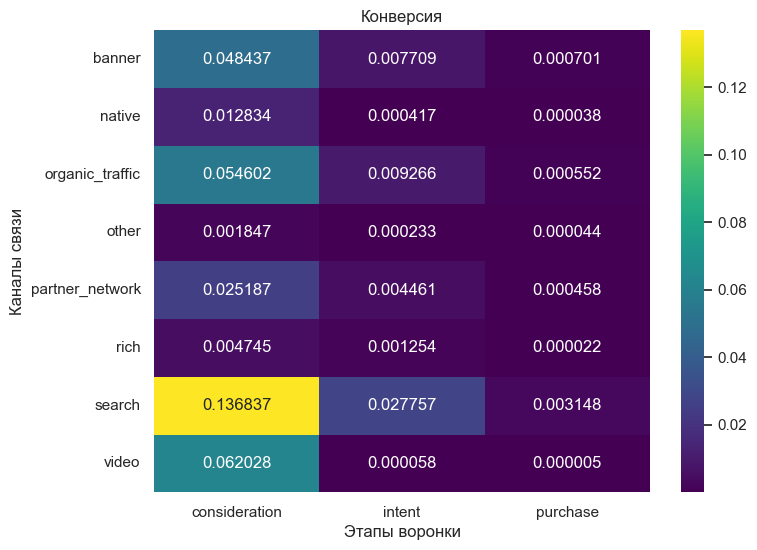

In [70]:
# Построение тепловой карты
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(pivot_df, annot=True, fmt=".6f", cmap='viridis')

# Настройка заголовка и меток осей
heatmap.set_title('Конверсия')
heatmap.set_xlabel('Этапы воронки')
heatmap.set_ylabel('Каналы связи')

# Отображение графика
plt.show()

### Клиент, представляющий онлайн-кинотеатр, хотел бы исключить хуже всего работающий канал. Аргументированно опишите, какой канал будет отключён и как можно перераспределить показы, чтобы увеличить продажи. Формулируйте гипотезы, полагаясь на результаты анализа, полученные в предыдущих блоках.

Так как прибыль ориносит клиент только на этапе покупки, то стоит исключить тот канал, на котором конверсия ниже всего именно на этом этапе. Это канал video, с конверсией всего 0.000005 отнисительно общего числа пользователей.
На этапе purchase лучшим каналом является search с конверсией 0.0031. Поэтому стоит перераспределить показы в его пользу. 